In [1]:
import os
import pickle
import sys
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from domid.arg_parser import mk_parser_main
from domid.mk_exp import mk_exp
from domid.models.model_ae import mk_ae
from domid.models.model_sdcn import mk_sdcn

In [2]:
HER2_PATH = '/storage6T/HER2/Testing_fixed/categorized/combined_train/'

# this is to make sure results are saved in the directory structure as expected
os.chdir('../')
os.getcwd()

'/storage2T/github/DomId'

## Helper Functions

In [3]:
def get_most_recent_directory(directory):
    try:
        directories = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
        directories.sort(key=lambda x: os.path.getctime(os.path.join(directory, x)), reverse=True)
        return os.path.join(directory, directories[0])
    except Exception as e:
        print("Error:", e)
        return None

In [4]:
def load_files(path):
    df = pd.read_csv(os.path.join(path, 'clustering_results.csv'))
    
    domain = df['predictions'].values
    
    vec_d = df['vec_d_labels'].values
    vec_y = df['vec_y_labels'].values
    img_locs = df['image_id_labels'].values

    Z = np.load(os.path.join(path, "Z_space.npy"))
    model_name = path.split('_')[-1]
    with open(os.path.join(path, 'commandline_arguments.p'), 'rb') as file:
        command_line = pickle.load(file)
    
    return domain, vec_d, vec_y, img_locs, model_name, command_line

In [5]:
def something_per_domain(domain, another_label):
    """
    domain - predicted domain labels 
    another_label - some other label that corresponds to each of the predicted domain (
    assumed that both domain and something have the same img_loc reference order 
    """
    u_something = np.unique(another_label)
    u_domain = np.unique(domain)
    print('unique predicted domain', u_domain)
    print('unique true label', u_something)
    
    array_counters=[]
    for i in u_domain:
        for j in u_something:
            counter = 0
            for idx in range(0, len(domain)):
                if domain[idx]==i and another_label[idx]==j:
                    counter+=1
            
            array_counters.append(counter)
    return array_counters

In [6]:
def plot_something_per_domain_proportion(domain, another_label, counts, fs, legend = False, thres = None, title = None, digit_plot = True):
    """
    domain - predicted domain labels
    another_label - another label aassociated with each predicted domain (should be same shape as domain)
    counts - countes of each another label in each of the predicted domain (see something_per_domain function)
    fs - font size
    colors - colors of each segment on the bargraph
    legend - legend of unique another lables
    thres - if thresholding of another label is required then should be shpecifies (also see apply_threshold function)
    
    """
    u_domains = np.unique(domain)
    N = len(u_domains)
    
    u_another_label = np.unique(another_label)
    print('unique labels', u_another_label)
    print(u_domains)
    counts = np.array(counts)
    narray = np.array_split(counts, N)

    if thres:
        u_another_label_dic = apply_threshold(u_another_label, narray, thres, N)
        #print(u_another_label_dic.values())
        u_another_label = list(u_another_label_dic.keys())
        narray = list(u_another_label_dic.values())
        narray = np.transpose(narray)

   # print(narray)
    #print(len(u_domains), len(u_another_label))
    # c = ['blue', 'teal', 'pink', 'orange', 'green', 'red', 'plum', 'grey', 'purple', 'yellow']
    # c = ['lightblue', 'steelblue', 'royalblue', 'mediumpurple', 'darkmagenta','orchid', 'lightpink', 'lightcoral', 'maroon', 'sandybrown']
    
    if digit_plot:
        c =  ['darkseagreen', 'forestgreen', 'aquamarine', 'lightseagreen', 'teal', 'steelblue','lightblue', 'royalblue','navy', 'lightslategrey' ]

    else:
        c = ['mediumpurple', 'darkmagenta','orchid', 'lightpink', 'lightcoral', 'maroon', 'sandybrown', 'peachpuff', 'goldenrod', 'gold']
  
        
    plt.figure(figsize = (5, 5))
    for i in range(0, len(u_domains)):
        for jj in range(0,len(u_another_label)):
            
            if jj>0:
                bottom = np.sum(narray[i][:jj])/np.sum(narray[i])
            else:
                bottom = 0
            ##print(i, narray[i][jj])
            #print(c[jj])
            plt.bar(i, narray[i][jj]/np.sum(narray[i]), bottom = bottom, color = c[jj])
    x = np.linspace(0, N-1, N)
    x_ticks = [str(item) for item in u_domains]
    #plt.ylabel("Proportion", fontsize=fs)
    plt.xticks(x, x_ticks, fontsize=fs)
    plt.yticks(fontsize=fs)
    plt.xlabel("Domain", fontsize=fs)
    plt.title(title, fontsize = fs, weight = 'bold')
    plt.tick_params(left = False, labelleft = False)
    if legend:
        plt.legend(legend, bbox_to_anchor=(1, 1.1))
    else:
        plt.legend(u_another_label, bbox_to_anchor=(1, 1.1), fancybox=True, shadow=True, fontsize = fs)
    plt.show()

In [7]:
def get_last_created_directory(path):
    directories = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
    directories.sort(key=lambda x: os.path.getctime(os.path.join(path, x)), reverse=True)
    if directories:
        return directories[0]
    else:
        return None

## VaDe Experiments with HER2 data

In [8]:
# equivalent experiment run from command line:
# poetry run python main_out.py --te_d 0 --tr_d 0 1 2 
# --task=her2 --epos=15 --aname=vade --zd_dim=500 --d_dim=3 
# --apath=domid/algos/builder_vade.py --L=5 --pre_tr=4 --dpath "../../HER2/combined_train" --bs 4 --prior Gaus --model cnn --lr 0.000005

In [9]:
exp = mk_exp(task='her2',model='vade',trainer='cluster', train_domain ="0 1 2", test_domain="0", batchsize="4",
             dpath= HER2_PATH, zd_dim='500', model_method ='cnn',
             prior='Gaus', pre_tr='4', epos=50, d_dim='3',lr='0.000005', nocu=False)

The sets of training and test domains overlap -- be aware of data leakage or training to the test!


Namespace(config_file=None, lr=5e-06, gamma_reg=0.1, es=1, seed=0, nocu=False, device=None, gen=False, keep_model=False, epos=50, epos_min=0, epo_te=1, warmup=100, debug=False, dmem=False, no_dump=False, trainer='cluster', out='zoutput', dpath='/storage6T/HER2/Testing_fixed/categorized/combined_train/', tpath=None, npath=None, npath_dom=None, npath_argna2val=None, nname_argna2val=None, nname=None, nname_dom=None, apath=None, exptag='exptag', aggtag='aggtag', bm_dir=None, plot_data=None, outp_dir='zoutput/benchmarks/shell_benchmark', param_idx=True, msel='val', model='vade', acon=None, task='her2', bs=4, split=0, te_d=['0'], tr_d=['0', '1', '2'], san_check=False, san_num=8, loglevel='DEBUG', zd_dim=500, zx_dim=0, zy_dim=64, topic_dim=3, nname_encoder_x2topic_h=None, npath_encoder_x2topic_h=None, nname_encoder_sandwich_x2h4zd=None, npath_encoder_sandwich_x2h4zd=None, gamma_y=None, gamma_d=None, beta_t=1.0, beta_d=1.0, beta_x=1.0, beta_y=1.0, tau=0.05, epos_per_match_update=5, epochs_ctr=

/storage2T/cache/pypoetry/virtualenvs/domid-99PrLA_U-py3.10/lib/python3.10/site-packages/domainlab/tasks/a_task.py:169: RuntimeWarning: The sets of training and test domains overlap -- be aware of data leakage or training to the test!
  warnings.warn(

using device: cuda

The sets of training and test domains overlap -- be aware of data leakage or training to the test!
/storage2T/cache/pypoetry/virtualenvs/domid-99PrLA_U-py3.10/lib/python3.10/site-packages/domainlab/tasks/a_task.py:169: RuntimeWarning: The sets of training and test domains overlap -- be aware of data leakage or training to the test!
  warnings.warn(


ConvolutionalEncoder(
  (encod): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Flatten(start_dim=1, end_dim=-1)
  )
  (mu_layer): Linear(in_features=2048, out_features=500, bias=True)
  (log_sigma2_layer): Linear(in_features=2048, out_features=500, bias=True)
)
ConvolutionalDecoder(
  (linear): Linear(in_features=500, out_features=2048, bias=True)
  (sigmoid_layer): Sigmoid()
  (unflat): UnFlatten()
  (decod)




!!!: not committed yet
/storage2T/cache/pypoetry/virtualenvs/domid-99PrLA_U-py3.10/lib/python3.10/site-packages/domainlab/utils/get_git_tag.py:16: UserWarning: !!!: not committed yet
  warnings.warn("!!!: not committed yet")



b'a9990e3'
The sets of training and test domains overlap -- be aware of data leakage or training to the test!
/storage2T/cache/pypoetry/virtualenvs/domid-99PrLA_U-py3.10/lib/python3.10/site-packages/domainlab/tasks/a_task.py:169: RuntimeWarning: The sets of training and test domains overlap -- be aware of data leakage or training to the test!
  warnings.warn(
model name: her2_te_class0_vade_ba9990e3_not_commited_2024md_04md_16_17_15_40_seed_0


############################################################
Pretraining initialized.
############################################################
______Created directory to save result_________


In [10]:
exp.execute()


 Experiment start at : 2024-04-16 17:15:40.381725
before training, model accuracy: (0.5, array([[336, 168, 168],
       [  0,   0,   0],
       [  0,   0,   0]]), 0.5416666666666666, array([[364,  60, 248],
       [  0,   0,   0],
       [  0,   0,   0]]))
Epoch 1. Pretraining.


/storage2T/cache/pypoetry/virtualenvs/domid-99PrLA_U-py3.10/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/storage2T/cache/pypoetry/virtualenvs/domid-99PrLA_U-py3.10/lib/python3.10/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


[nan, nan, nan, nan, nan, nan]


/storage2T/cache/pypoetry/virtualenvs/domid-99PrLA_U-py3.10/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/storage2T/cache/pypoetry/virtualenvs/domid-99PrLA_U-py3.10/lib/python3.10/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


[nan, nan, nan, nan, nan, nan]
pi:
[0.2725869  0.23689826 0.49051479]
epoch: 1
[0.03556859924576085, -0.0681822164375799, -0.041922112797339296, 0.041922112797339296, 0.003136228608357269, 0.06900503359198469]
[0.028878677566388768, -0.02555845929184312, 0.004631372546682629, -0.004631372546682618, 0.022370165928391132, 0.015373937033674217]
pooled train clustering acc (vec_d correlation):  0.45089285714285715
[[ 45   9  63]
 [ 31   9  52]
 [172  42 249]]
clustering validation acc:  0.45535714285714285
[[ 37  11  52]
 [ 23   9  52]
 [188  40 260]]
pooled train clustering acc (vec_y correlation):  0.40476190476190477
[[ 28  25  47]
 [ 24  22  38]
 [116 121 251]]
Correlation with HER2 scores training 0.06900503359198469
Correlation with HER2 scores validation 0.028878677566388768
now:  2024-04-16 17:16:25.685384 epoch time:  0:00:45.303659 used:  0:00:45.303659
Epoch 2. Pretraining.
[0.07567123555632455, -0.012170909825455793, 0.0929047483427386, -0.0929047483427386, 0.09584399308977484,

/storage2T/github/DomId/domid/utils/storing.py:141: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(row, ignore_index=True)
/storage2T/github/DomId/domid/algos/observers/c_obvisitor_clustering.py:107: UserWarning: failed to delete model
  warnings.warn("failed to delete model")


In [11]:
vade_path = get_last_created_directory('./notebooks/')
print(vade_path)

2024-04-16_17:15:40.338172_her2_vade


In [12]:
domain, vec_d, vec_y, img_locs, model_name, command_line = load_files('./notebooks/'+vade_path)

unique predicted domain [1 2 3]
unique true label [0 1 2]
unique labels [0 1 2]
[1 2 3]


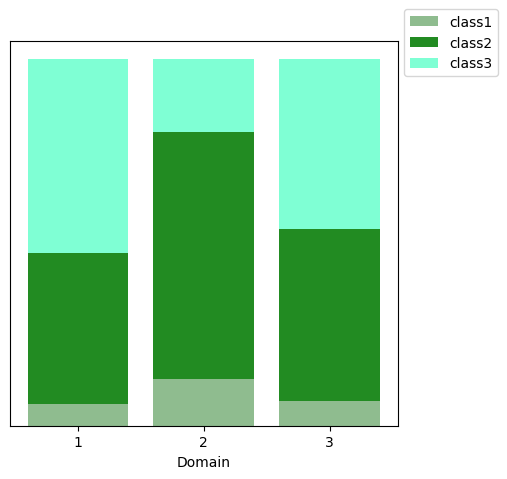

In [13]:
vec_d_counters = something_per_domain(domain, vec_d)
plot_something_per_domain_proportion(domain, vec_d, vec_d_counters, 10, legend = ['class1', 'class2', 'class3'], thres = None, title = None, digit_plot = True)

unique predicted domain [1 2 3]
unique true label [0 1 2]
unique labels [0 1 2]
[1 2 3]


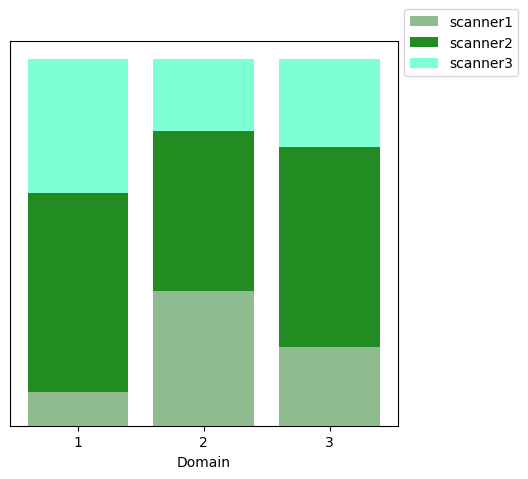

In [14]:
vec_y_counters = something_per_domain(domain, vec_y)
plot_something_per_domain_proportion(domain, vec_y, vec_y_counters, 10, legend = ['scanner1', 'scanner2', 'scanner3'], thres = None, title = None, digit_plot = True)

## DEC Experiments with HER2 data

In [15]:
exp = mk_exp(task='her2',model='dec',trainer='cluster', train_domain ="0 1 2", test_domain="0", batchsize="4",
             dpath= HER2_PATH, zd_dim='500', model_method ='cnn',
             prior='Gaus', pre_tr='4', epos=50, d_dim='3',lr='0.000005', nocu=False)

Namespace(config_file=None, lr=5e-06, gamma_reg=0.1, es=1, seed=0, nocu=False, device=None, gen=False, keep_model=False, epos=50, epos_min=0, epo_te=1, warmup=100, debug=False, dmem=False, no_dump=False, trainer='cluster', out='zoutput', dpath='/storage6T/HER2/Testing_fixed/categorized/combined_train/', tpath=None, npath=None, npath_dom=None, npath_argna2val=None, nname_argna2val=None, nname=None, nname_dom=None, apath=None, exptag='exptag', aggtag='aggtag', bm_dir=None, plot_data=None, outp_dir='zoutput/benchmarks/shell_benchmark', param_idx=True, msel='val', model='dec', acon=None, task='her2', bs=4, split=0, te_d=['0'], tr_d=['0', '1', '2'], san_check=False, san_num=8, loglevel='DEBUG', zd_dim=500, zx_dim=0, zy_dim=64, topic_dim=3, nname_encoder_x2topic_h=None, npath_encoder_x2topic_h=None, nname_encoder_sandwich_x2h4zd=None, npath_encoder_sandwich_x2h4zd=None, gamma_y=None, gamma_d=None, beta_t=1.0, beta_d=1.0, beta_x=1.0, beta_y=1.0, tau=0.05, epos_per_match_update=5, epochs_ctr=1

The sets of training and test domains overlap -- be aware of data leakage or training to the test!
/storage2T/cache/pypoetry/virtualenvs/domid-99PrLA_U-py3.10/lib/python3.10/site-packages/domainlab/tasks/a_task.py:169: RuntimeWarning: The sets of training and test domains overlap -- be aware of data leakage or training to the test!
  warnings.warn(

using device: cuda

The sets of training and test domains overlap -- be aware of data leakage or training to the test!
/storage2T/cache/pypoetry/virtualenvs/domid-99PrLA_U-py3.10/lib/python3.10/site-packages/domainlab/tasks/a_task.py:169: RuntimeWarning: The sets of training and test domains overlap -- be aware of data leakage or training to the test!
  warnings.warn(



!!!: not committed yet
/storage2T/cache/pypoetry/virtualenvs/domid-99PrLA_U-py3.10/lib/python3.10/site-packages/domainlab/utils/get_git_tag.py:16: UserWarning: !!!: not committed yet
  warnings.warn("!!!: not committed yet")



b'a9990e3'
The sets of training and test domai

############################################################
Pretraining initialized.
############################################################
______Created directory to save result_________


In [16]:
exp.execute()


 Experiment start at : 2024-04-16 17:49:57.959182
before training, model accuracy: (0.4806547619047619, array([[307, 157, 152],
       [  0,   0,   0],
       [ 29,  11,  16]]), 0.5327380952380952, array([[335,  56, 225],
       [  0,   0,   0],
       [ 29,   4,  23]]))
Epoch 1. Pretraining.


/storage2T/cache/pypoetry/virtualenvs/domid-99PrLA_U-py3.10/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/storage2T/cache/pypoetry/virtualenvs/domid-99PrLA_U-py3.10/lib/python3.10/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


[0.020054335537774047, -0.020054335537774047, 0.020054335537774047, -0.02005433553777403, 0.020054335537774047, nan]


/storage2T/cache/pypoetry/virtualenvs/domid-99PrLA_U-py3.10/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/storage2T/cache/pypoetry/virtualenvs/domid-99PrLA_U-py3.10/lib/python3.10/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


[-0.04152728851333531, 0.04152728851333528, -0.04152728851333528, 0.04152728851333535, -0.04152728851333528, nan]
epoch: 1
[0.00799686720407945, 0.3456582680497632, 0.29225068461899445, -0.29225068461899445, 0.18020602448559292, -0.35513499171758567]
[-0.020843798469138055, 0.3445222853262707, 0.2604511637504322, -0.2604511637504322, 0.14666713589357733, -0.3336697628369136]
pooled train clustering acc (vec_d correlation):  0.43452380952380953
[[117 145  22]
 [ 50 170  33]
 [ 81  49   5]]
clustering validation acc:  0.46726190476190477
[[135 138  15]
 [ 42 174  40]
 [ 71  52   5]]
pooled train clustering acc (vec_y correlation):  0.4226190476190476
[[162  58  68]
 [107  94  55]
 [ 67  16  45]]
Correlation with HER2 scores training 0.3456582680497632
Correlation with HER2 scores validation 0.3445222853262707
now:  2024-04-16 17:50:43.052392 epoch time:  0:00:45.093210 used:  0:00:45.093210
Epoch 2. Pretraining.
[0.04438847718943374, 0.32647898499748934, 0.31048494584340947, -0.310484945

/storage2T/github/DomId/domid/utils/storing.py:141: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(row, ignore_index=True)
/storage2T/github/DomId/domid/algos/observers/c_obvisitor_clustering.py:107: UserWarning: failed to delete model
  warnings.warn("failed to delete model")


In [17]:
dec_path = get_last_created_directory('./notebooks/')
print(dec_path)

2024-04-16_17:49:57.887274_her2_dec


In [18]:
domain, vec_d, vec_y, img_locs, model_name, command_line = load_files('./notebooks/'+dec_path)

unique predicted domain [1 2 3]
unique true label [0 1 2]
unique labels [0 1 2]
[1 2 3]


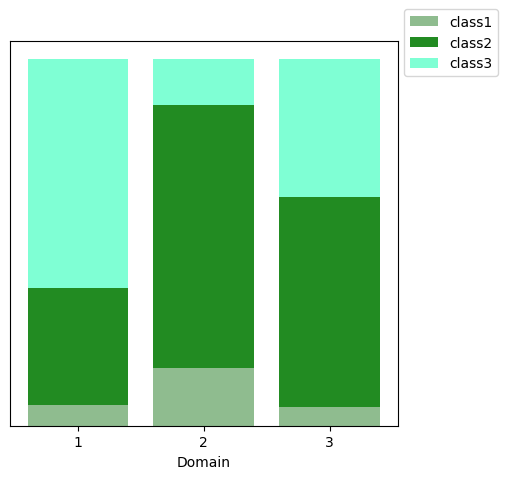

In [19]:
vec_d_counters = something_per_domain(domain, vec_d)
plot_something_per_domain_proportion(domain, vec_d, vec_d_counters, 10, legend = ['class1', 'class2', 'class3'], thres = None, title = None, digit_plot = True)

unique predicted domain [1 2 3]
unique true label [0 1 2]
unique labels [0 1 2]
[1 2 3]


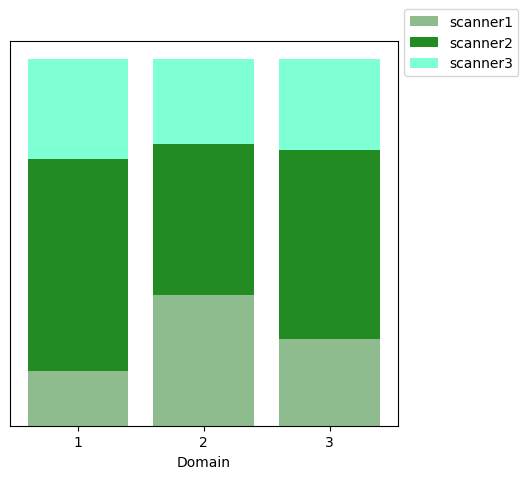

In [20]:
vec_y_counters = something_per_domain(domain, vec_y)
plot_something_per_domain_proportion(domain, vec_y, vec_y_counters, 10, legend = ['scanner1', 'scanner2', 'scanner3'], thres = None, title = None, digit_plot = True)

## CDVaDE Experiments with HER2 data

In [21]:
# equivalent experiment run from command line:
# poetry run python main_out.py --te_d 0 --tr_d 0 1 2 --task=her2 --epos=15 --aname=vade --zd_dim=500 
#    --d_dim=3 --apath=domid/algos/builder_vade.py --L=5 --pre_tr=4 --dpath "../../HER2/combined_train" 
#    --bs 4 --prior Gaus --model cnn --lr 0.000005 --dim_inject_y 3 --inject_var "class"

exp = mk_exp(task='her2',model='vade',trainer='cluster', train_domain ="0 1 2", test_domain="0", batchsize="4",
             dpath=HER2_PATH, zd_dim='500', model_method ='cnn',
             prior='Gaus', pre_tr='4', epos=50, d_dim='3',lr='0.000005', dim_inject_y=3,
             meta_data_csv=os.path.join(HER2_PATH, 'dataframe.csv'),  inject_var='class', nocu=False)

The sets of training and test domains overlap -- be aware of data leakage or training to the test!


Namespace(config_file=None, lr=5e-06, gamma_reg=0.1, es=1, seed=0, nocu=False, device=None, gen=False, keep_model=False, epos=50, epos_min=0, epo_te=1, warmup=100, debug=False, dmem=False, no_dump=False, trainer='cluster', out='zoutput', dpath='/storage6T/HER2/Testing_fixed/categorized/combined_train/', tpath=None, npath=None, npath_dom=None, npath_argna2val=None, nname_argna2val=None, nname=None, nname_dom=None, apath=None, exptag='exptag', aggtag='aggtag', bm_dir=None, plot_data=None, outp_dir='zoutput/benchmarks/shell_benchmark', param_idx=True, msel='val', model='vade', acon=None, task='her2', bs=4, split=0, te_d=['0'], tr_d=['0', '1', '2'], san_check=False, san_num=8, loglevel='DEBUG', zd_dim=500, zx_dim=0, zy_dim=64, topic_dim=3, nname_encoder_x2topic_h=None, npath_encoder_x2topic_h=None, nname_encoder_sandwich_x2h4zd=None, npath_encoder_sandwich_x2h4zd=None, gamma_y=None, gamma_d=None, beta_t=1.0, beta_d=1.0, beta_x=1.0, beta_y=1.0, tau=0.05, epos_per_match_update=5, epochs_ctr=

/storage2T/cache/pypoetry/virtualenvs/domid-99PrLA_U-py3.10/lib/python3.10/site-packages/domainlab/tasks/a_task.py:169: RuntimeWarning: The sets of training and test domains overlap -- be aware of data leakage or training to the test!
  warnings.warn(

using device: cuda

The sets of training and test domains overlap -- be aware of data leakage or training to the test!
/storage2T/cache/pypoetry/virtualenvs/domid-99PrLA_U-py3.10/lib/python3.10/site-packages/domainlab/tasks/a_task.py:169: RuntimeWarning: The sets of training and test domains overlap -- be aware of data leakage or training to the test!
  warnings.warn(


ConvolutionalEncoder(
  (encod): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Flatten(start_dim=1, end_dim=-1)
  )
  (mu_layer): Linear(in_features=2048, out_features=500, bias=True)
  (log_sigma2_layer): Linear(in_features=2048, out_features=500, bias=True)
)
ConvolutionalDecoder(
  (linear): Linear(in_features=503, out_features=2048, bias=True)
  (sigmoid_layer): Sigmoid()
  (unflat): UnFlatten()
  (decod)




!!!: not committed yet
/storage2T/cache/pypoetry/virtualenvs/domid-99PrLA_U-py3.10/lib/python3.10/site-packages/domainlab/utils/get_git_tag.py:16: UserWarning: !!!: not committed yet
  warnings.warn("!!!: not committed yet")



b'a9990e3'
The sets of training and test domains overlap -- be aware of data leakage or training to the test!
/storage2T/cache/pypoetry/virtualenvs/domid-99PrLA_U-py3.10/lib/python3.10/site-packages/domainlab/tasks/a_task.py:169: RuntimeWarning: The sets of training and test domains overlap -- be aware of data leakage or training to the test!
  warnings.warn(
model name: her2_te_class0_vade_ba9990e3_not_commited_2024md_04md_16_18_23_41_seed_0


############################################################
Pretraining initialized.
############################################################
______Created directory to save result_________


In [22]:
exp.execute()


 Experiment start at : 2024-04-16 18:23:41.402010
before training, model accuracy: (0.5, array([[336, 168, 168],
       [  0,   0,   0],
       [  0,   0,   0]]), 0.5416666666666666, array([[364,  60, 248],
       [  0,   0,   0],
       [  0,   0,   0]]))
Epoch 1. Pretraining.


/storage2T/cache/pypoetry/virtualenvs/domid-99PrLA_U-py3.10/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/storage2T/cache/pypoetry/virtualenvs/domid-99PrLA_U-py3.10/lib/python3.10/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


[nan, nan, nan, nan, nan, nan]


/storage2T/cache/pypoetry/virtualenvs/domid-99PrLA_U-py3.10/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/storage2T/cache/pypoetry/virtualenvs/domid-99PrLA_U-py3.10/lib/python3.10/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


[nan, nan, nan, nan, nan, nan]
pi:
[0.3304639  0.4197258  0.24981034]
epoch: 1
[0.0061048045525947375, 0.01185834227772371, 0.013995922190891828, -0.013995922190891828, 0.011896649367641818, -0.014137411174027007]
[0.02516793264549103, 0.006516784634637286, 0.02434400254619607, -0.02434400254619607, 0.027829501879606346, -0.017632274366074834]
pooled train clustering acc (vec_d correlation):  0.4211309523809524
[[ 79 117  12]
 [131 192  36]
 [ 38  55  12]]
clustering validation acc:  0.4494047619047619
[[ 91 105  18]
 [125 198  29]
 [ 32  61  13]]
pooled train clustering acc (vec_y correlation):  0.4166666666666667
[[ 58 108  48]
 [ 82 178  92]
 [ 28  50  28]]
Correlation with HER2 scores training 0.013995922190891828
Correlation with HER2 scores validation 0.027829501879606346
now:  2024-04-16 18:24:28.216328 epoch time:  0:00:46.814318 used:  0:00:46.814318
Epoch 2. Pretraining.
[0.07175503030567669, -0.05954048795929937, 0.003345584791606213, -0.003345584791606231, 0.038102559068676

/storage2T/github/DomId/domid/utils/storing.py:141: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(row, ignore_index=True)
/storage2T/github/DomId/domid/algos/observers/c_obvisitor_clustering.py:107: UserWarning: failed to delete model
  warnings.warn("failed to delete model")


In [23]:
cdvade_path = get_last_created_directory('./notebooks/')

In [24]:
cdvade_path

'2024-04-16_18:23:41.357723_her2_vade'

In [25]:
domain, vec_d, vec_y, img_locs, model_name, command_line = load_files('./notebooks/'+cdvade_path)

unique predicted domain [1 2 3]
unique true label [0 1 2]
unique labels [0 1 2]
[1 2 3]


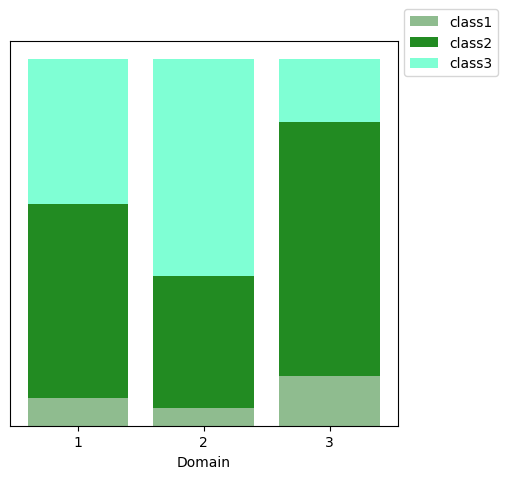

In [26]:
vec_d_counters = something_per_domain(domain, vec_d)
plot_something_per_domain_proportion(domain, vec_d, vec_d_counters, 10, legend = ['class1', 'class2', 'class3'], thres = None, title = None, digit_plot = True)

unique predicted domain [1 2 3]
unique true label [0 1 2]
unique labels [0 1 2]
[1 2 3]


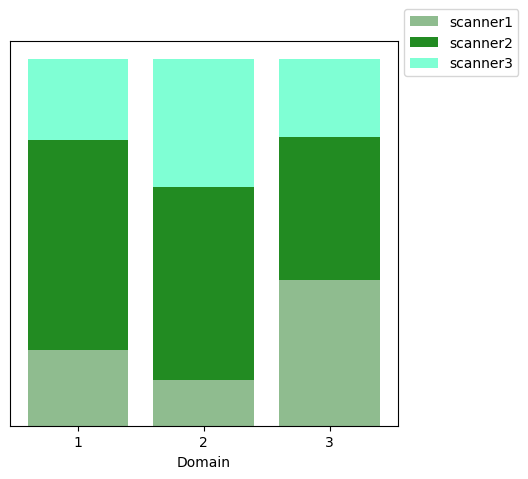

In [27]:
vec_y_counters = something_per_domain(domain, vec_y)
plot_something_per_domain_proportion(domain, vec_y, vec_y_counters, 10, legend = ['scanner1', 'scanner2', 'scanner3'], thres = None, title = None, digit_plot = True)

**To Perform further analysys, please follow to the notebook 'HER2_boxplot_visualizations.ipynb'!**

You will need the directories for the results of the experiments.

Example: 

ex_dec = './notebooks/2024-04-15_11:42:21.990399_her2_dec/'

ex_vade = './notebooks/2024-04-12_13:23:14.404120_her2_vade/'

Note that if you ran this entire notebook, then you have already assigned `vade_path`,`cdvade_path` and `dec_path`:

In [28]:
print(cdvade_path)
print(vade_path)
print(dec_path)

2024-04-16_18:23:41.357723_her2_vade
2024-04-16_17:15:40.338172_her2_vade
2024-04-16_17:49:57.887274_her2_dec
